In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import bisect
from scipy import spatial

In [36]:
def distmat(X, Z):
    return spatial.distance.cdist(X,Z)**2

def W(X,sigma):
    similarities = np.exp( -distmat(X,X)/(2*sigma**2) )
    np.fill_diagonal(similarities, 0)
    return similarities

In [3]:
n, p = 200, 2 # number of agents, dimension
n1 = int(3*n/4)
n2 = n-n1
t, R = 2*np.pi*np.random.randn(n1,1), 3
r = R*(1.5 + .2*np.random.randn(n1,1)) # radius
X1 = np.hstack((np.cos(t)*r, np.sin(t)*r));
X = np.vstack((X1, np.random.randn(n2,2)))
y = np.vstack(( np.ones([n1,1]), 2*np.ones([n2,1]) ))

(-5.914137948582541, 5.843744481955645, -6.028493149993848, 5.569680487903251)

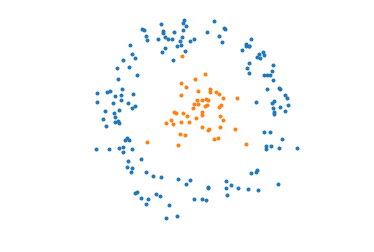

In [4]:
I = np.nonzero(y==1)[0]
J = np.nonzero(y==2)[0]
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.axis('equal')
plt.axis('off')

In [5]:
def create_data(x, y ,nsamples=1000):
    if y==1:
        data = np.random.poisson(np.linalg.norm(x), nsamples)
    elif y==2:
        data = ss.expon.rvs(np.linalg.norm(x), size=nsamples)
    else:
        print("choose y in {1,2}")
    return data

In [6]:
i, j = np.random.choice(I), np.random.choice(J)
print('i=', i, 'et j=', j)
print('data for an element of I : ', create_data(X[i], y[i] ,nsamples=10))
print('data for an element of J : ', create_data(X[j], y[j] ,nsamples=10))

i= 68 et j= 173
data for an element of I :  [6 7 1 3 6 4 5 4 4 3]
data for an element of J :  [3.92037331 3.76086983 3.13697164 3.22276728 2.62748207 2.67454206
 2.21701939 7.43656909 2.8794214  2.75943313]


In [14]:
DATA = [create_data(X[k], y[k], nsamples=5000) for k in range(n)]

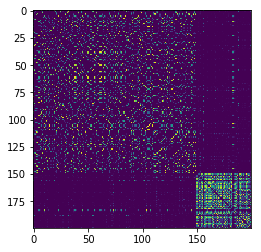

In [37]:
sigma = 1
K = W(X,sigma)
plt.imshow(K)

In [16]:
def methode_Noyau(data, K=ss.norm.pdf):
    nsamples = len(data)
    sigma = data.std()
    h = sigma/nsamples**(0.2) # thumb rule
    densite = lambda y : np.sum([K((y-x)/h) for x in data])/(nsamples*h)
    return densite

def methode_MC(data):
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob =  Nb_occurences/np.sum(Nb_occurences)
    return ensemble_des_valeurs, prob

Regardons comment obtenir la densité d'un échantillon pour $y=1$.

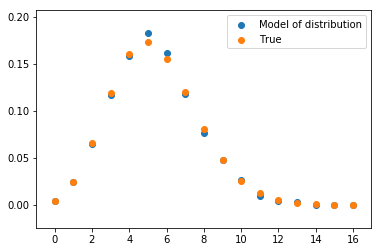

In [17]:
data = DATA[i]
ensemble_des_valeurs, prob = methode_MC(data)
plt.scatter(ensemble_des_valeurs, prob, label='Model of distribution')
plt.scatter(ensemble_des_valeurs, ss.poisson.pmf(ensemble_des_valeurs,np.linalg.norm(X[i])), label='True')
plt.legend()

Regardons comment obtenir la densité d'un échantillon pour $y=2$.

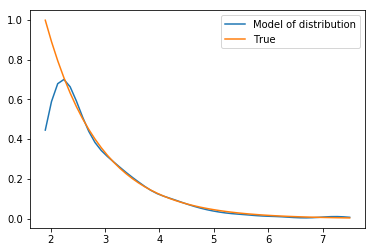

In [10]:
data = DATA[j]
densite = methode_Noyau(data)
tt = np.linspace(np.min(data), np.max(data), 50)
plt.plot(tt, [densite(t) for t in tt], label='Model of distribution')
plt.plot(tt, ss.expon.pdf(tt,np.linalg.norm(X[j])), label='True')
plt.legend()

Maintenant qu'on a les densités de probabilités, il faut obtenir les fonctions $g_s(v)$. Pour ça, on calcule la fonction de répartition empirique : 

In [18]:
def F(data):
    nsamples = len(data)
    data_sorted = np.sort(data)
    return lambda t : bisect.bisect(data_sorted,t)/nsamples

def g(data):
    nsamples = len(data)
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob_cum = np.cumsum(Nb_occurences)/nsamples
    return prob_cum, ensemble_des_valeurs

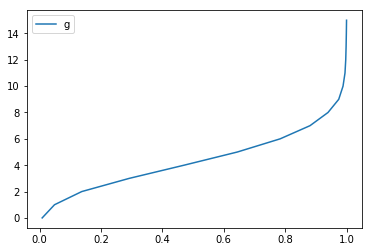

In [22]:
data = DATA[np.random.randint(n)]
xx, yy = g(data)
plt.plot(xx, yy, label='g')
plt.legend()

Désormais, affichons les fonction g pour deux sommets proches.

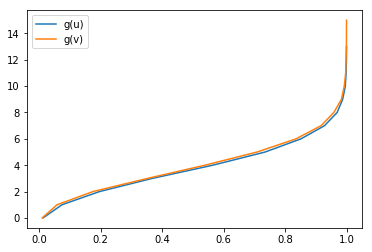

In [44]:
G = [g(data) for data in DATA]
u = np.random.randint(n)
v = np.argmax(K[u])

xx, yy = G[u]
plt.plot(xx, yy, label='g(u)')
xx, yy = G[v]
plt.plot(xx, yy, label='g(v)')
plt.legend()

Nous constatons que les sommets proches ont une inverse de leur fonction de répartition très similaires. En conclusion, ils peuvent échanger de l'information pour mieux apprendre leurs modèles.